# Imports

In [227]:
import string

In [228]:
import numpy as np

In [229]:
import pandas as pd

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

In [231]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OneHotEncoder, StandardScaler, MaxAbsScaler, Normalizer, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

In [232]:
from scipy.stats import randint, uniform

# Functions

In [233]:
def inspect_df(df : pd.DataFrame):
    """
    Display basic structural information about a DataFrame.

    This function prints the number of rows and columns, checks for
    missing values, and displays the data types of each feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be inspected.

    Returns
    -------
    None
        This function does not return any value. It prints
        summary information to the console.

    Notes
    -----
    - If no missing values are present, the function explicitly
      prints that there are zero null values.
    - If missing values exist, the function prints the number
      of null values for each column.
    - Feature data types are displayed using `df.dtypes`.
    """
    print(f'Rows:       {df.shape[0]}')
    print(f'Columns:    {df.shape[1]}')
    print("-" * 30)

    null_values = df.isna().sum()
    if (null_values.sum() == 0):
        print('Null values: 0')
    else:
        print('Null values:')
        print(null_values)
    
    print("-" * 30)
    print('Feature data types:')
    print(df.dtypes)
    print("")

In [234]:
def check_balance(df : pd.DataFrame, target_col : str):
    """
    Check the class distribution of a target column in a dataset.

    This function computes the percentage distribution of each class
    in the specified target column and prints the results. It also
    displays the ideal percentage share per class for a perfectly
    balanced dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the dataset.
    target_col : str
        Name of the target column whose class distribution
        needs to be evaluated.

    Returns
    -------
    None
        This function does not return any value. It prints
        the class distribution and balance information.

    Notes
    -----
    - Percentages are computed using normalized value counts
      and rounded to two decimal places.
    - The dataset can be considered balanced if the class
      percentages are close to the ideal equal share
      (100 / number_of_classes).
    - The function assumes that `target_col` exists in `df`.
    """
    value_counts = (df[target_col].value_counts(normalize=True) * 100).round(2)
    ideal_share = 100 / len(value_counts)
    
    print(f'Value counts for {target_col}:')
    print(value_counts)
    print("-" * 30)
    print(f'The dataset is balanced if the value counts are close to {ideal_share:.2f}%')

In [235]:
def plot_scatter(df : pd.DataFrame, x_feature : str, y_feature : str):
    """
    Generate a scatter plot for two selected features from a DataFrame.

    This function creates a scatter plot using the specified columns
    as x and y axes and displays the plot.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the data to be plotted.
    x_feature : str
        Name of the column to be used as the x-axis.
    y_feature : str
        Name of the column to be used as the y-axis.

    Returns
    -------
    None
        This function does not return any value. It displays the plot.

    Notes
    -----
    - The function assumes that both `x_feature` and `y_feature`
      exist in the provided DataFrame.
    - No additional styling or customization is applied to the plot.
    """
    plt.scatter(df[x_feature], df[y_feature])
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

In [236]:
def evaluate_classifier(model, x_test, y_test, title: str, f1_average: str = 'binary', f1_pos_label=1):
    """
    Evaluate the performance of a classification model on a test dataset.

    This function computes Accuracy and F1-score, prints the results,
    and displays the confusion matrix normalized by rows.

    Parameters
    ----------
    model : estimator
        A trained classification model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True labels corresponding to `x_test`.
    title : str
        Descriptive title to display in the output and on the confusion matrix plot.
    f1_average : str, default='binary'
        Averaging method used to compute the F1-score.
        Common options include: 'binary', 'micro', 'macro', 'weighted'.
    f1_pos_label : int or str, default=1
        The label considered as the positive class when `f1_average='binary'`.

    Returns
    -------
    y_pred : array-like
        Predicted labels generated by the model on `x_test`.

    Notes
    -----
    - The confusion matrix is displayed normalized by rows (`normalize='true'`),
      meaning values represent proportions relative to the true class.
    - Metrics are printed with four decimal places.
    """
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=f1_average, pos_label=f1_pos_label)

    print("")
    print(f"{title.title()}:")
    print(f"Accuracy:                   {accuracy:.4f}")
    print(f"F1 score ({f1_average}):        {f1:.4f}")

    disp = ConfusionMatrixDisplay.from_predictions(
        y_pred, y_test,
        cmap=plt.cm.Blues, 
        normalize='true'    # 'true' normalize on rows
    )
    disp.ax_.set_title(title.title())
    plt.show()

    return y_pred

In [237]:
def evaluate_regressor(model, x_test, y_test):
    """
    Evaluate the performance of a regression model on a test dataset.

    This function generates predictions using the provided model and
    computes common regression metrics: MAE, MSE, MSLE (if applicable),
    and R² score. The results are printed to the console.

    Parameters
    ----------
    model : estimator
        A trained regression model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True target values corresponding to `x_test`.

    Returns
    -------
    y_pred : array-like
        Predicted values generated by the model on `x_test`.

    Notes
    -----
    - MAE (Mean Absolute Error) measures the average absolute difference
      between true and predicted values.
    - MSE (Mean Squared Error) penalizes larger errors more heavily.
    - MSLE (Mean Squared Logarithmic Error) is computed only if all true
      and predicted values are greater than -1. Otherwise, it is not
      applicable.
    - R² score is bounded in the interval (-∞, 1]. Values below 0
      indicate that the model performs worse than a baseline model
      predicting the mean target value.
    """
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    if (y_test > -1).all() & (y_pred > -1).all():
        msle = mean_squared_log_error(y_test, y_pred)
    else:
        msle = "N/A (y_test contiene valori <= -1)"
    r2 = r2_score(y_test, y_pred)

    print("")
    print(f"MAE:    {mae}")
    print(f"MSE:    {mse}")
    print(f"MSLE:   {msle}")
    print(f"R2:     {r2}")
    print("")
    print("Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.")

    return y_pred

In [238]:
def kfold_crossvalidation(model, x_train, y_train, cv : int, title : str):
    """
    Perform K-Fold cross-validation on a given model.

    This function evaluates a model using cross-validation,
    prints the mean and standard deviation of the obtained
    scores, and returns the full array of cross-validation results.

    Parameters
    ----------
    model : estimator
        A machine learning model implementing the scikit-learn API.
    x_train : array-like
        Feature matrix of the training dataset.
    y_train : array-like
        Target values corresponding to `x_train`.
    cv : int
        Number of folds for K-Fold cross-validation.
        (Note: the current implementation uses `cv=10` internally.)
    title : str
        Descriptive title to display in the printed output.

    Returns
    -------
    outputs : numpy.ndarray
        Array containing the cross-validation scores for each fold.

    Notes
    -----
    - Cross-validation is performed using `cross_val_score`
      with parallel processing enabled (`n_jobs=-1`).
    - The function prints the mean and standard deviation
      of the cross-validation scores.
    """
    outputs = cross_val_score(model, x_train, y_train, cv=10, n_jobs=-1)

    print(f'{title.title()}:')
    print(f'Mean:   {outputs.mean()}')
    print(f'Std:    {outputs.std()}')
    print('-' * 30)
    return outputs

In [ ]:
def gender_parity(model, x_test, feature_name : str, m_label, f_label):
    """
    Compare model predictions between two groups identified by a feature.

    This function splits the test set into two subsets based on the values
    of a specified categorical feature (e.g., gender), generates predictions
    for each group, and prints the total number of positive predictions.

    Parameters
    ----------
    model : estimator
        A trained classification model implementing the `predict` method.
    x_test : pandas.DataFrame
        Test feature set containing the specified grouping feature.
    feature_name : str
        Name of the column used to distinguish between the two groups
        (e.g., a gender column).
    m_label : any
        Value in `feature_name` identifying the first group (e.g., male).
    f_label : any
        Value in `feature_name` identifying the second group (e.g., female).

    Returns
    -------
    None
        This function does not return any value. It prints
        the number of positive predictions for each group.

    Notes
    -----
    - The function assumes that the model outputs binary predictions
      (e.g., 0 and 1), and that summing predictions corresponds to
      counting the positive class.
    - The feature specified by `feature_name` must exist in `x_test`.
    - This can be used as a simple fairness diagnostic to check
      potential disparities in model predictions between groups.
    """
    m_mask = x_test[feature_name] == m_label
    f_label = x_test[feature_name] == f_label
    male = (model.predict(x_test[m_mask])).sum()
    female = (model.predict(x_test[f_label])).sum()
    print(f'Male:    {male}')
    print(f'Female:  {female}')

In [240]:
def get_categorical_features(df : pd.DataFrame):
    return df.select_dtypes(include=['object']).columns

In [241]:
def get_k_correlated(df : pd.DataFrame, y_name : str, k : int, abs : bool, ascending : bool):
    """
    Retrieve the names of the top-k features most correlated with a target variable.

    This function computes the correlation matrix of the DataFrame and
    returns the names of the k features with the highest (or lowest)
    correlation with the specified target column.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing numerical features.
    y_name : str
        Name of the target column for which correlations are computed.
    k : int
        Number of correlated features to retrieve.
    abs : bool
        If True, correlations are sorted by their absolute values.
        If False, raw correlation values are used.
    ascending : bool
        Sorting order of correlations.
        If True, correlations are sorted in ascending order.
        If False, correlations are sorted in descending order.

    Returns
    -------
    pandas.Index
        Index containing the names of the top-k correlated features,
        excluding the target variable itself.

    Notes
    -----
    - The function assumes that `y_name` exists in `df` and that the
      DataFrame contains only numerical columns for correlation computation.
    - The first element (self-correlation of the target) is excluded
      from the result.
    """
    if (abs):
        y_corr = df.corr()[y_name].abs().sort_values(ascending=ascending)
    else:
        y_corr = df.corr()[y_name].sort_values(ascending=ascending)
    return y_corr[1:(k+1)].index

In [242]:
def pfi(model, x_test, y_test):
    pfi = permutation_importance(model, x_test, y_test, n_jobs=-1)
    fig, ax = plt.subplots()
    pd.Series(pfi['importances_mean']).plot.bar(yerr=pfi['importances_std'], ax=ax)
    ax.set_title("Permutation Feature Importance")
    ax.set_ylabel('Importance')
    fig.tight_layout()
    plt.show()

In [243]:
def clean_text(text : str):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Exam

In [244]:
backup = pd.read_csv('./dataset.csv', sep=',')
df = backup.copy()
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [245]:
inspect_df(df)

Rows:       10000
Columns:    14
------------------------------
Null values: 0
------------------------------
Feature data types:
RowNumber            int64
CustomerId           int64
Surname                str
CreditScore          int64
Geography              str
Gender                 str
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object



In [246]:
check_balance(df, 'Exited')

Value counts for Exited:
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64
------------------------------
The dataset is balanced if the value counts are close to 50.00%


In [247]:
df['Age'] = pd.cut(df['Age'], bins=5)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,"(32.8, 47.6]",2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,"(32.8, 47.6]",1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,"(32.8, 47.6]",8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,"(32.8, 47.6]",1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,"(32.8, 47.6]",2,125510.82,1,1,1,79084.10,0


In [248]:
((df.groupby('Age')['Exited'].mean()) * 100).round(2)

Age
(17.926, 32.8]     7.63
(32.8, 47.6]      18.82
(47.6, 62.4]      53.00
(62.4, 77.2]      21.49
(77.2, 92.0]       4.17
Name: Exited, dtype: float64

In [249]:
df['Age'] = backup['Age']
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [250]:
df[(df['Age'] > 60)].groupby('Exited')['Balance'].mean()

Exited
0    70420.165731
1    91895.016435
Name: Balance, dtype: float64

In [251]:
df['EstimatedSalary'] = pd.cut(df['EstimatedSalary'], bins=5)
pivot = df.pivot_table(index=['Gender'], columns=['EstimatedSalary'], values=['CreditScore'], aggfunc='mean')
pivot

CreditScore                       \
EstimatedSalary (-188.401, 40007.76] (40007.76, 80003.94]   
Gender                                                      
Female                    657.436219           651.474747   
Male                      649.769731           650.378284   

                                                             \
EstimatedSalary (80003.94, 120000.12] (120000.12, 159996.3]   
Gender                                                        
Female                     646.934899            646.401064   
Male                       649.466117            649.247855   

                                       
EstimatedSalary (159996.3, 199992.48]  
Gender                                 
Female                     652.440357  
Male                       652.460346

<Axes: >

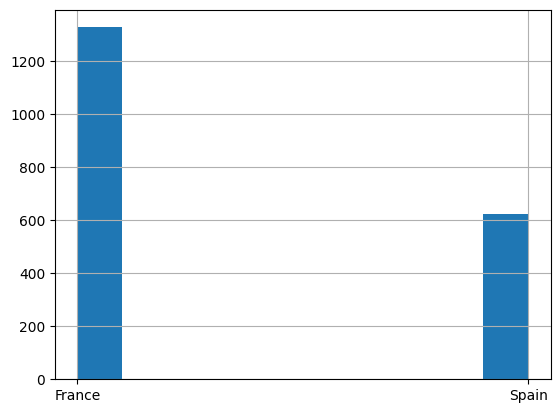

In [252]:
df['EstimatedSalary'] = backup['EstimatedSalary']
df.loc[(df['HasCrCard'] == 1) & (df['Balance'] > 100000) & (df['Geography'] != 'Germany'), 'Geography'].hist()

In [253]:
df = backup.copy()
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [254]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df = df.dropna()
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [255]:
cat_features = get_categorical_features(df)
df[cat_features] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit_transform(df[cat_features])
df.head()

/tmp/ipykernel_19410/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.0,0.0,42,2,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2,125510.82,1,1,1,79084.10,0


In [256]:
X, y = df.drop(columns='Exited'), df['Exited']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)


Decision Tree:
Accuracy:                   0.7836
F1 score (binary):        0.4891


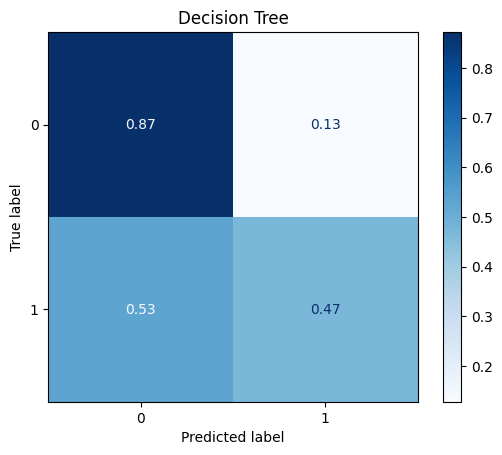

array([0, 0, 0, ..., 0, 0, 0], shape=(2500,))

In [257]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
evaluate_classifier(dt, x_test, y_test, 'decision tree')


K Neighbors:
Accuracy:                   0.7612
F1 score (binary):        0.1285


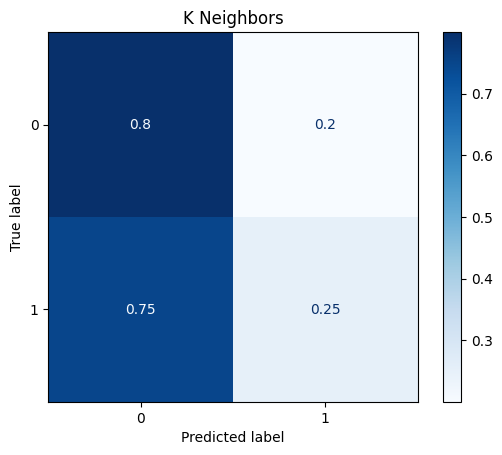

array([0, 0, 0, ..., 0, 0, 0], shape=(2500,))

In [258]:
kn = KNeighborsClassifier()
kn.fit(x_train, y_train)
evaluate_classifier(kn, x_test, y_test, 'k neighbors')


Dummy:
Accuracy:                   0.7964
F1 score (binary):        0.0000


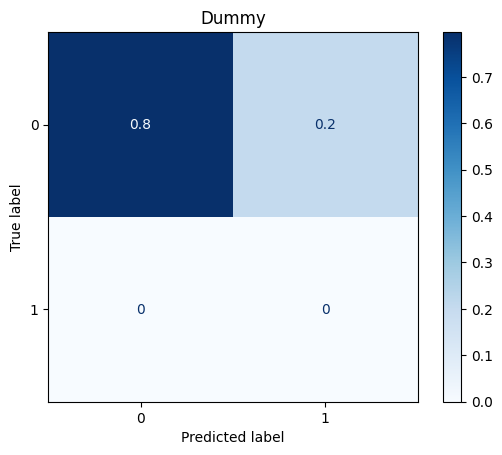

array([0, 0, 0, ..., 0, 0, 0], shape=(2500,))

In [259]:
dc = DummyClassifier()
dc.fit(x_train, y_train)
evaluate_classifier(dc, x_test, y_test, 'dummy')

In [260]:
kfold_crossvalidation(DecisionTreeClassifier(), x_train, y_train, 10, 'decision tree')
kfold_crossvalidation(KNeighborsClassifier(), x_train, y_train, 10, 'k neighbors')
kfold_crossvalidation(DummyClassifier(), x_train, y_train, 10, 'dummy')

Decision Tree:
Mean:   0.7904
Std:    0.010376040777783313
------------------------------
K Neighbors:
Mean:   0.7636000000000001
Std:    0.009296116273895122
------------------------------
Dummy:
Mean:   0.7962666666666667
Std:    0.0005333333333333189
------------------------------


array([0.79733333, 0.79733333, 0.796     , 0.796     , 0.796     ,
       0.796     , 0.796     , 0.796     , 0.796     , 0.796     ])

In [262]:
gender_parity(dt, x_test, 'Gender', m_label=1.0, f_label=0.0)

Male:    245
Female:  305
